# Assignment 1

Deadline: 19.03.2025, 12:00 CET

*Buchkov Viacheslav, ID = 24-742-488, viacheslav.buchkov@uzh.ch*

In [437]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
from typing import Optional
from dataclasses import dataclass

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)
from src.estimation.covariance import Covariance
from src.estimation.expected_return import ExpectedReturn
from src.optimization.constraints import Constraints
from src.optimization.optimization import Optimization, Objective
from src.optimization.optimization_data import OptimizationData
from src.optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

In [438]:
@dataclass
class GroupConstraint:
    indicies: np.array
    max_weight: float

@dataclass
class TaskConfig:
    RANDOM_SEED: int = 121

    TOTAL_EXPOSURE: float = 1.0

    MIN_WEIGHT: float = 0.0
    MAX_WEIGHT: float = 0.2

    GROUP_CONSTRAINTS: tuple[GroupConstraint] = (
        GroupConstraint(indicies=np.arange(0, 30), max_weight=0.3),
        GroupConstraint(indicies=np.arange(30, 60), max_weight=0.4),
        GroupConstraint(indicies=np.arange(60, 100), max_weight=0.5)
    )

task_config = TaskConfig()

## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [439]:
LOW_RETURN = -0.03 / 252
HIGH_RETURN = 0.15 / 252

LOW_VOL = 0.03 / np.sqrt(252)
HIGH_VOL = 0.25 / np.sqrt(252)

# Set the dimensions
T = 1_000  # Number of time periods
N = 100   # Number of assets

np.random.seed(task_config.RANDOM_SEED)

# Generate a random mean vector and covariance matrix for the multivariate normal distribution
mean = np.random.uniform(low=LOW_RETURN, high=HIGH_RETURN, size=N)
vols = np.random.uniform(low=LOW_VOL, high=HIGH_VOL, size=N)
correlations = np.random.uniform(low=-1, high=1, size=N * (N - 1) // 2)

In [440]:
corr_matrix = np.eye(N)
upper_indices = np.triu_indices(N, k=1)
corr_matrix[upper_indices] = correlations
corr_matrix = corr_matrix + corr_matrix.T - np.eye(N)

In [441]:
def nearest_positive_semidefinite(matrix: np.array) -> np.array:
    matrix = (matrix + matrix.T) / 2
    eigvals, eigvecs = np.linalg.eigh(matrix)
    eigvals[eigvals < 0] = 0
    psd_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    return psd_matrix

corr_matrix = nearest_positive_semidefinite(corr_matrix)

In [442]:
def var_covar_from_corr_array(corr_array: np.array, volatilities: np.array) -> np.array:
    return volatilities @ corr_array @ volatilities

In [443]:
cov = var_covar_from_corr_array(corr_matrix, np.diag(np.sqrt(vols)))
cov.shape

(100, 100)

In [444]:
# Generate the Multivariate-Normal random dataset
data = np.random.multivariate_normal(mean, cov, size=T)

# Convert the dataset to a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns) from df
# As we sample normal => returns are arithmetic (not compounded)
expected_return = ExpectedReturn(method="arithmetic")
q = expected_return.estimate(X=df, inplace=False)

# Compute the covariance matrix from df
covariance = Covariance()
P = covariance.estimate(X=df, inplace=False)

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)

Vector of expected returns (q):
Asset_1      0.000311
Asset_2      0.002907
Asset_3     -0.001299
Asset_4     -0.009561
Asset_5     -0.005422
               ...   
Asset_96     0.011851
Asset_97    -0.001216
Asset_98    -0.001203
Asset_99    -0.005681
Asset_100   -0.007430
Length: 100, dtype: float64

Covariance matrix (P):
            Asset_1   Asset_2   Asset_3   Asset_4   Asset_5   Asset_6  \
Asset_1    0.044199 -0.006243 -0.003509 -0.007416 -0.003027 -0.003019   
Asset_2   -0.006243  0.021743 -0.003579  0.000837  0.000653  0.001091   
Asset_3   -0.003509 -0.003579  0.022771  0.005781  0.002170 -0.006947   
Asset_4   -0.007416  0.000837  0.005781  0.024616  0.002044 -0.002882   
Asset_5   -0.003027  0.000653  0.002170  0.002044  0.006222  0.001149   
...             ...       ...       ...       ...       ...       ...   
Asset_96   0.001016 -0.002976  0.005875 -0.002851 -0.000637  0.004390   
Asset_97  -0.001247  0.001770  0.000078  0.001112  0.000241 -0.000111   
Asset_98  -0.0026

In [445]:
df.min().min(), df.max().max()

(np.float64(-0.9713765347350374), np.float64(0.863534808275182))

### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [446]:
# Instantiate the Constraints class
constraints = Constraints(ids=df.columns.tolist())

# Add budget constraint
constraints.add_budget(rhs=task_config.TOTAL_EXPOSURE, sense='=')

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(lower=task_config.MIN_WEIGHT, upper=task_config.MAX_WEIGHT)

# Add linear constraints
groups_mask = pd.DataFrame(np.zeros((len(task_config.GROUP_CONSTRAINTS), N)), columns=constraints.ids)

maximum_weights = []
for i, group_constraint in enumerate(task_config.GROUP_CONSTRAINTS):
    groups_mask.iloc[i, group_constraint.indicies] = 1
    maximum_weights.append(group_constraint.max_weight)

maximum_weights = pd.Series(maximum_weights)
constraints.add_linear(G=groups_mask, sense='<=', rhs=maximum_weights)

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [447]:
# Extract the constraints in the format required by the solver
GhAb = constraints.to_GhAb()

# Loop over solvers, instantiate the quadratic program, solve it and store the results
results = pd.DataFrame(columns=['solution_found', 'objective', 'primal_residual', 'dual_residual', 'duality_gap', 'runtime'], index=list(USABLE_SOLVERS))
for solver_name in USABLE_SOLVERS:
    solver_settings = {'solver_name': solver_name}
    model = QuadraticProgram(
        P=P.to_numpy(),
        q=q.to_numpy() * -1,
        G=GhAb['G'],
        h=GhAb['h'],
        A=GhAb['A'],
        b=GhAb['b'],
        lb = constraints.box['lower'].to_numpy(),
        ub = constraints.box['upper'].to_numpy(),
        solver_settings=solver_settings,
    )
    start_time = timeit.default_timer()
    model.solve()
    runtime = timeit.default_timer() - start_time

    results.loc[solver_name, 'solution_found'] = model.results['solution'].found
    results.loc[solver_name, 'objective'] = model.results['solution'].obj
    results.loc[solver_name, 'primal_residual'] = model.results['solution'].primal_residual() if model.results['solution'].found else ['NA']
    results.loc[solver_name, 'dual_residual'] = model.results['solution'].dual_residual() if model.results['solution'].found else ['NA']
    results.loc[solver_name, 'duality_gap'] = model.results['solution'].duality_gap() if model.results['solution'].found else ['NA']
    results.loc[solver_name, 'runtime'] = runtime


# Extract runtime, accuracy, reliability

In [448]:
results

,solution_found,objective,primal_residual,dual_residual,duality_gap,runtime
qpalm,True,-0.008261,0.0,0.0,6.500447433658478e-08,0.014636
quadprog,True,-0.008261,0.0,0.0,6.500447433658478e-08,0.018427
highs,True,-0.008261,0.0,0.0,6.500447433658478e-08,0.019049
daqp,True,-0.008261,0.0,0.0,6.500447433658478e-08,0.017999
osqp,True,-0.008261,0.0,0.0,6.500447433658478e-08,0.01803
cvxopt,True,-0.008261,0.0,0.0,6.500447433658478e-08,0.017941


Print and visualize the results

In [449]:
assert results["solution_found"].all(), "Not all solutions found!"

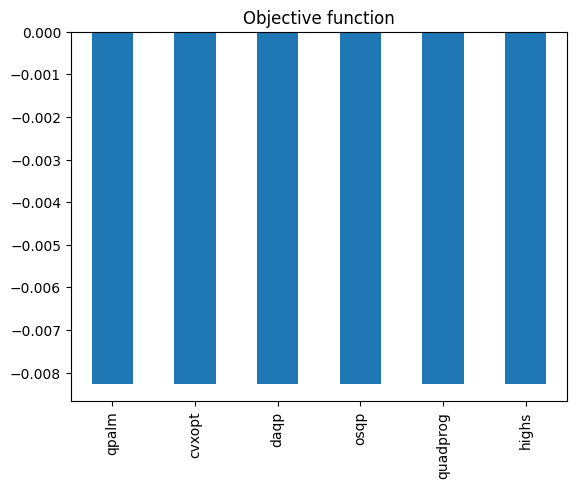

In [450]:
sort_order = results["runtime"].sort_values(ascending=True).index

results.loc[sort_order, "objective"].plot(kind='bar', title='Objective function');

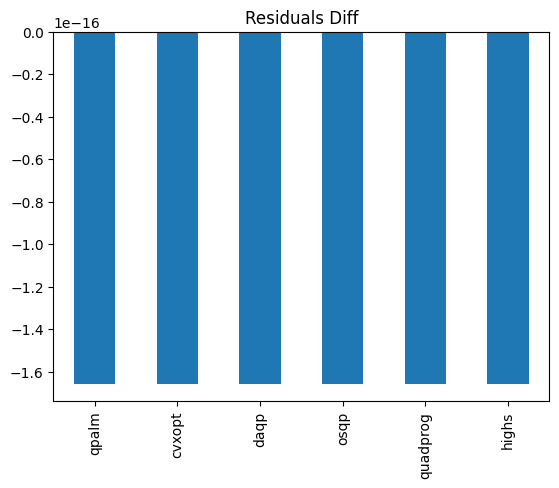

In [451]:
(results.loc[sort_order, "primal_residual"] - results.loc[sort_order, "dual_residual"]).plot(kind='bar', title='Residuals Diff');

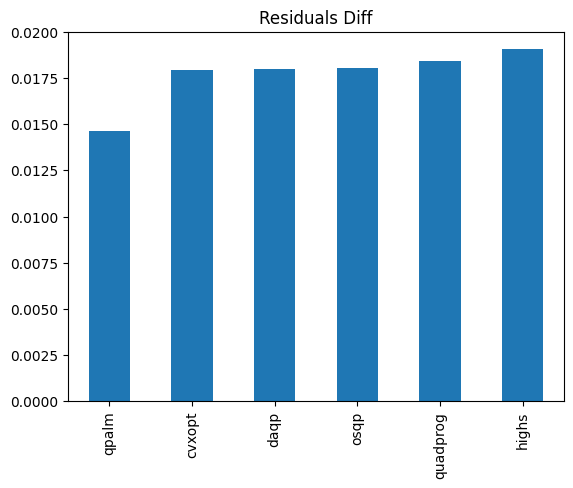

In [452]:
results.loc[sort_order, "runtime"].plot(kind='bar', title='Residuals Diff');

## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [453]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

        self.asset_names = constraints.ids

    def set_objective(self, optimization_data: OptimizationData) -> None:
        """From the data computes the covariance matrix."""
        X = optimization_data['return_series']
        covmat = self.covariance.estimate(X=X, inplace=False)
        self.objective = Objective(
            P = covmat,
        )
        return None

    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            assert all(constr is None for constr in self.constraints.linear.values()), "Linear constraints are not supported for analytical solver."

            GhAb = self.constraints.to_GhAb()
            obj_coeff = self.objective.coefficients

            Sigma = obj_coeff['P']
            A = GhAb['A']
            b = GhAb['b']

            if b.ndim == 0:
                b = b.reshape(-1, 1)

            inner_matrix_inv = np.linalg.inv(A @ np.linalg.inv(Sigma) @ A.T)
            weights = np.linalg.inv(Sigma) @ A.T @ inner_matrix_inv @ b
            weights = list(weights.flatten())

            self.results.update({
                'weights': dict(zip(self.asset_names, weights)),
                'status': True
            })

            return None
        else:
            return super().solve()


# Create a constraints object with just a budget constraint# Instantiate the Constraints class
constraints = Constraints(ids=df.columns.tolist())
constraints.add_budget(rhs=task_config.TOTAL_EXPOSURE, sense='=')

# Instantiate the MinVariance class
min_variance = MinVariance(
    constraints=constraints,
    covariance=covariance,
    solver_name='analytical'
)

# Prepare the optimization data and prepare the optimization problem
optimization_data = OptimizationData(return_series=df)
min_variance.set_objective(optimization_data)

# Solve the optimization problem and print the weights
min_variance.solve()
optimal_weights = min_variance.results['weights']

assert np.isclose(sum(optimal_weights.values()), task_config.TOTAL_EXPOSURE, atol=1e-6), "Total exposure is not correct!"